In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
import time

%matplotlib inline

In [5]:
train_df =pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [6]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

### LGBM_model

### [LGBM parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [11]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
fold_n=10
folds = StratifiedKFold(n_splits=fold_n, shuffle=False, random_state=44000) 

In [14]:
# based on following kernel https://www.kaggle.com/dromosys/sctp-working-lgb
param = {'num_leaves': 9,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [15]:
%%time
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_+1))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, 
                    trn_data, 
                    num_round, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=1000, early_stopping_rounds = 3000)
    
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], 
                               num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.887662	valid_1's auc: 0.860789
[2000]	training's auc: 0.911746	valid_1's auc: 0.880183
[3000]	training's auc: 0.922877	valid_1's auc: 0.888473
[4000]	training's auc: 0.929431	valid_1's auc: 0.892978
[5000]	training's auc: 0.934175	valid_1's auc: 0.895333
[6000]	training's auc: 0.938238	valid_1's auc: 0.896613
[7000]	training's auc: 0.942142	valid_1's auc: 0.897108
[8000]	training's auc: 0.946007	valid_1's auc: 0.897184
[9000]	training's auc: 0.949618	valid_1's auc: 0.897296
[10000]	training's auc: 0.953108	valid_1's auc: 0.897339
[11000]	training's auc: 0.956459	valid_1's auc: 0.89738
[12000]	training's auc: 0.959616	valid_1's auc: 0.897295
[13000]	training's auc: 0.962613	valid_1's auc: 0.897235
[14000]	training's auc: 0.965405	valid_1's auc: 0.897152
Early stopping, best iteration is:
[11136]	training's auc: 0.956866	valid_1's auc: 0.89742
Fold 2
Training until validation scores don't impr

[12000]	training's auc: 0.959626	valid_1's auc: 0.89934
Early stopping, best iteration is:
[9839]	training's auc: 0.952598	valid_1's auc: 0.899604


NameError: name 'roc_auc_score' is not defined

C:\Users\SKTelecom\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


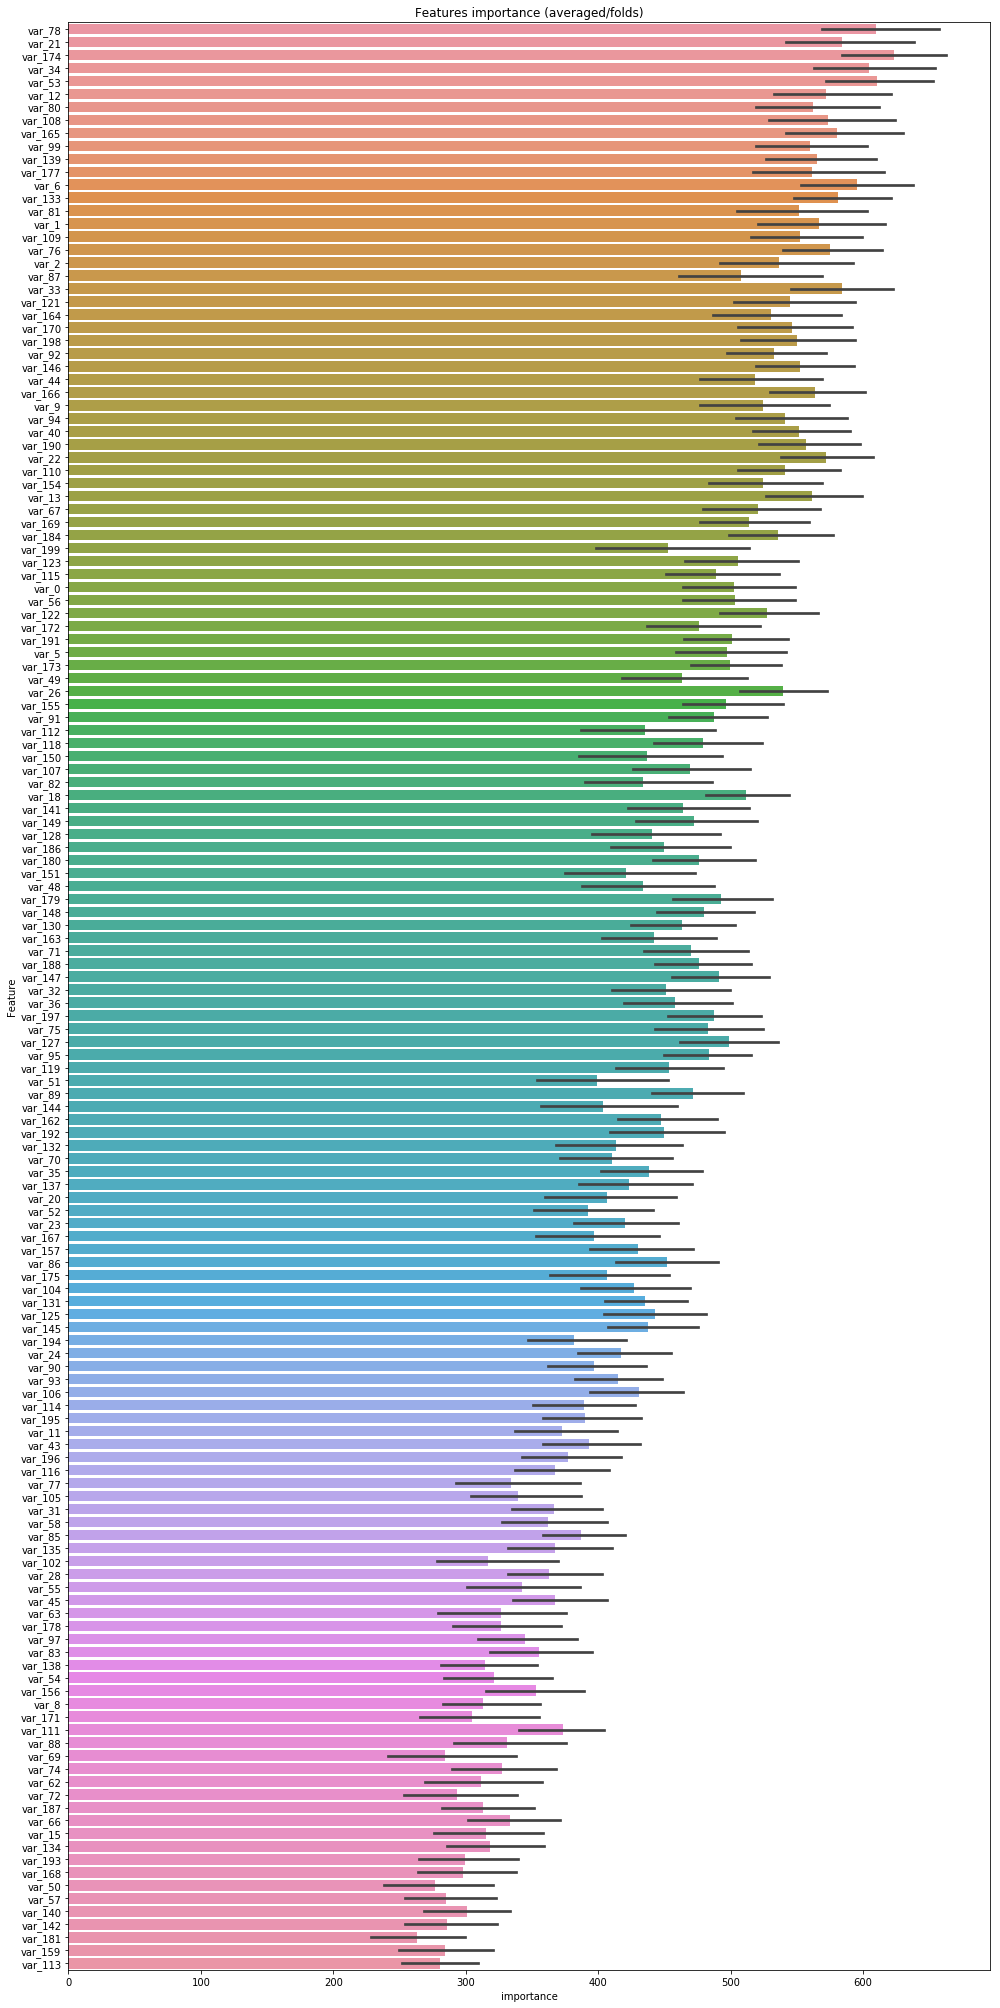

In [16]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [17]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("../submission/lgbm_190319.csv", index=False)